In [34]:
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import datetime as dt

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs 
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl


Getting Data

In [35]:
tickers = ['RELIANCE.NS','HDFCBANK.BO', 'INFY.BO', 'HINDUNILVR.BO']
# raw adjusted close prices
data = pdr.get_data_yahoo(tickers, start=dt.date.today()-dt.timedelta(500), end=dt.date.today())['Adj Close']
# log returns
log_rets = np.log(data/data.shift(1)).dropna()

# Stationarity
Conditions:
1. The mean of the series should not be a function of time.
2. The variance of the series should not be a function of time. This is also known as 'Homoskedasticity'.
3. The coveriance of the n th term and (n + m) th term should not be a function of time.

Why Stationarity?
1. A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.
2. Descriptive statistics predicted by these models such as means, variances, and correlations, are only reliable if the Time Series is stationary.

# Serial Correlation (Autocorrelation)
1. Represents the degree of similarity between a given time series and a lagged version of itself over successive time intervals
2. Measures the relationship between a variable's current value and its past values
3. Technical analysts can use autocorrelation to see how much of an impact past prices for a security have on its future price

<> Correlation between a time series and a delayed copy of itself.
<> Ignoring autocorrelation will mean model predictions will be bunk, and one is likely to draw incorrect conclusions about the impact of the independent variables in our model

Why autocorrelation?
1. To detect non-randomness in data
2. To identify an appropriate time series model if the data are not random

The autocorrelation plot can help provide answers to the following questions:
1. Are the data random?
2. Is an observation related to an adjacent observation?
3. Is an observation related to an observation twice-removed? (etc.)
4. Is the observed time series white noise?
5. Is the observed time series sinusoidal?
6. Is the observed time series autoregressive?

# Partial Autocorrelation
1. Partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags
2. It contrasts with the autocorrelation function, which does not control for other lags

<> Removes effect of previous time points
a partial autocorrelation function of order 3 returns the correlation between our time series (t_1, t_2, t_3, …) and its own values lagged by 3 time points (t_4, t_5, t_6, …), but only after removing all effects attributable to lags 1 and 2.
<> The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

The partial autocorrelation plot can help provide answers to the following questions:
1. Is an AR model appropriate for the data?
2. If an AR model is appropriate, what order should we use?

# White Noise and Random Walks
<> A time series is white noise if the variables are independent and identically distributed (i.i.d) with a mean of zero

Meaning that all variables have the same variance (sigma^2) and each value has a zero correlation with all other values in the series

White Noises are stationary.

<> A random walk is another time series model where the current observation is equal to the previous observation with a random step up or down.

Random walk are non stationary.

time series model xt = xt-1 + wt; wt is a discrete white noise series

In [44]:
def time_series_plot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)                      #convert into series first, if not already
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

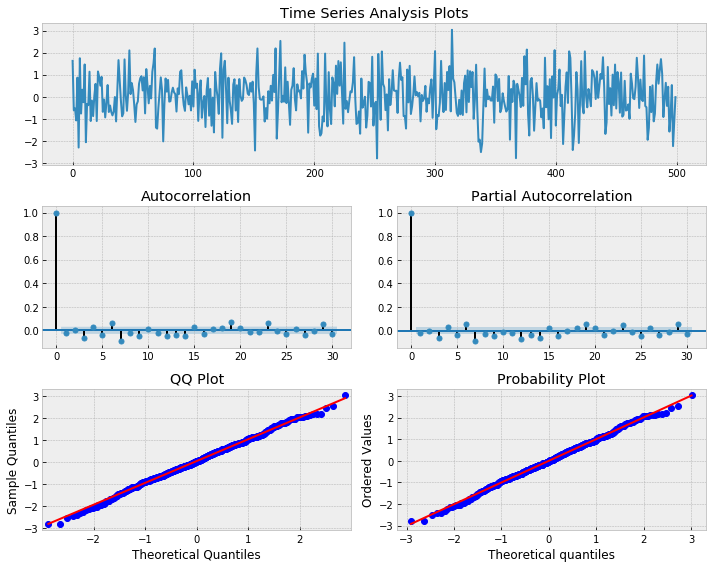

In [47]:
np.random.seed(1)

# plot of discrete white noise
randser = np.random.normal(size=500)
time_series_plot(randser, lags=30)

In [38]:
print("Random Series\n-------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

Random Series
-------------
mean: 0.053
variance: 0.977
standard deviation: 0.988


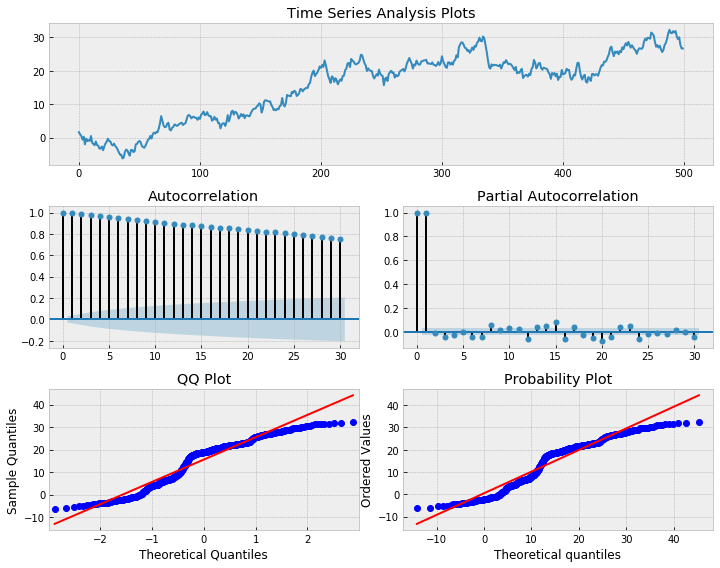

In [46]:
np.random.seed(1)
n_samples = 500

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]          #Random Walk without a drift

_ = time_series_plot(x, lags=30)

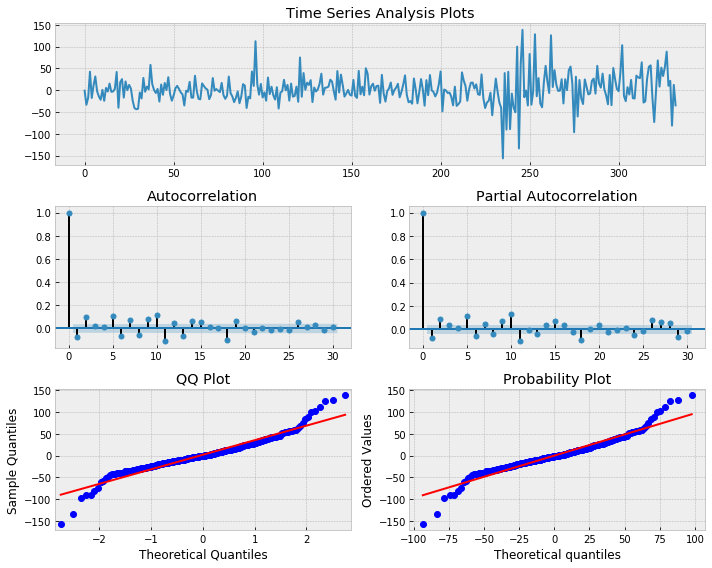

In [45]:
# First difference of RELIANCE prices
_ = time_series_plot(np.diff(data.iloc[:,0]), lags=30)